In [1]:
%run mnist_poison_util.py

(60000, 28, 28) (10000, 28, 28) (60000,) (10000,)
(60000, 28, 28, 1) (10000, 28, 28, 1) (60000, 10) (10000, 10)


# Directory Layout
All clean and poisoned models are in "poisoned_datasets/models/(clean or poisoned)" directories. For now, I don't think you would need to work with "poisoned_datasets/models/(train or test)" which harbors poisoned samples for each attack group. So far there are 144 attack groups for trainig with different goals such as location, size, value, target labels, etc. For training attack scenario. For each single scenario I have generated 10 random dataset that targetted different clean images in the dataset so it has 1440 different attack dataset in 144 groups.
At each folder there is a gtable* file which contains metadata for each poisoned dataset or poisoned models which is a pandas dataframe.

In [2]:
import pandas as pd
from myutil import read_bz2_ret_pickle
tr_table = read_bz2_ret_pickle("./poisoned_datasets/train/gtable.pickle.bz2")
tst_table = read_bz2_ret_pickle("./poisoned_datasets/test/gtable.pickle.bz2")
tr_table['location'] = tr_table['location'].apply(tuple)
tr_table['attack_labels'] = tr_table['attack_labels'].apply(tuple)

tst_table['location'] = tst_table['location'].apply(tuple)
tst_table['attack_labels'] = tst_table['attack_labels'].apply(tuple)
tr_grouped = tr_table.groupby(by=['location','color','attack_labels','attack_ratio'])
print ('Total Attacking Scenario supported is: {}'.format(tr_grouped.ngroups))
tr_table.sample(n=3)

Total Attacking Scenario supported is: 144


,location,color,attack_ratio,attack_labels,p_seed,is_train,file_loc
1050,"((10, 1),)",0.95,0.0015,"((1, 5),)",704711.0,1.0,./poisoned_datasets/train/pois_1050.pickle.bz2
673,"((2, 20),)",0.95,0.0100,"((0, 8),)",833505.0,1.0,./poisoned_datasets/train/pois_673.pickle.bz2
761,"((10, 1),)",0.05,0.0100,"((0, 8),)",949828.0,1.0,./poisoned_datasets/train/pois_761.pickle.bz2


In [3]:
tr_grouped_loc = tr_table.groupby(by=['location'])
print ('Total Attacking Scenario supported for location: {}'
       .format(tr_grouped_loc.ngroups))
tr_grouped_loc.count()

Total Attacking Scenario supported for location: 4


,color,attack_ratio,attack_labels,p_seed,is_train,file_loc
location,,,,,,
"((2, 2), (2, 3), (3, 2), (3, 3))",360,360,360,360,360,360
"((2, 20),)",360,360,360,360,360,360
"((10, 1),)",360,360,360,360,360,360
"((26, 26), (26, 27), (27, 26), (27, 27))",360,360,360,360,360,360


In [4]:
tr_grouped_atk_r = tr_table.groupby(by=['attack_ratio'])
print ('Total Attacking Scenario supported for attack ratio: {}'
       .format(tr_grouped_atk_r.ngroups))
tr_grouped_atk_r.count()

Total Attacking Scenario supported for attack ratio: 3


,location,color,attack_labels,p_seed,is_train,file_loc
attack_ratio,,,,,,
0.0015,480,480,480,480,480,480
0.0100,480,480,480,480,480,480
0.1000,480,480,480,480,480,480


In [5]:
tr_grouped_atk_lbl = tr_table.groupby(by=['attack_labels'])
print ('Total Attacking Scenario supported for attack labels: {}'
       .format(tr_grouped_atk_lbl.ngroups))
print ('(x,y) means labels are changed from x in clean to y in poisoned')
tr_grouped_atk_lbl.count()

Total Attacking Scenario supported for attack labels: 3
(x,y) means labels are changed from x in clean to y in poisoned


,location,color,attack_ratio,p_seed,is_train,file_loc
attack_labels,,,,,,
"((0, 8),)",480,480,480,480,480,480
"((1, 5),)",480,480,480,480,480,480
"((6, 9),)",480,480,480,480,480,480


In [6]:
tr_grouped_atk_color = tr_table.groupby(by=['color'])
print ('Total Attacking Scenario supported for color: {}'
       .format(tr_grouped_atk_color.ngroups))
tr_grouped_atk_color.count()

Total Attacking Scenario supported for color: 4


,location,attack_ratio,attack_labels,p_seed,is_train,file_loc
color,,,,,,
0.05,360,360,360,360,360,360
0.20,360,360,360,360,360,360
0.50,360,360,360,360,360,360
0.95,360,360,360,360,360,360


Populating the interactive namespace from numpy and matplotlib


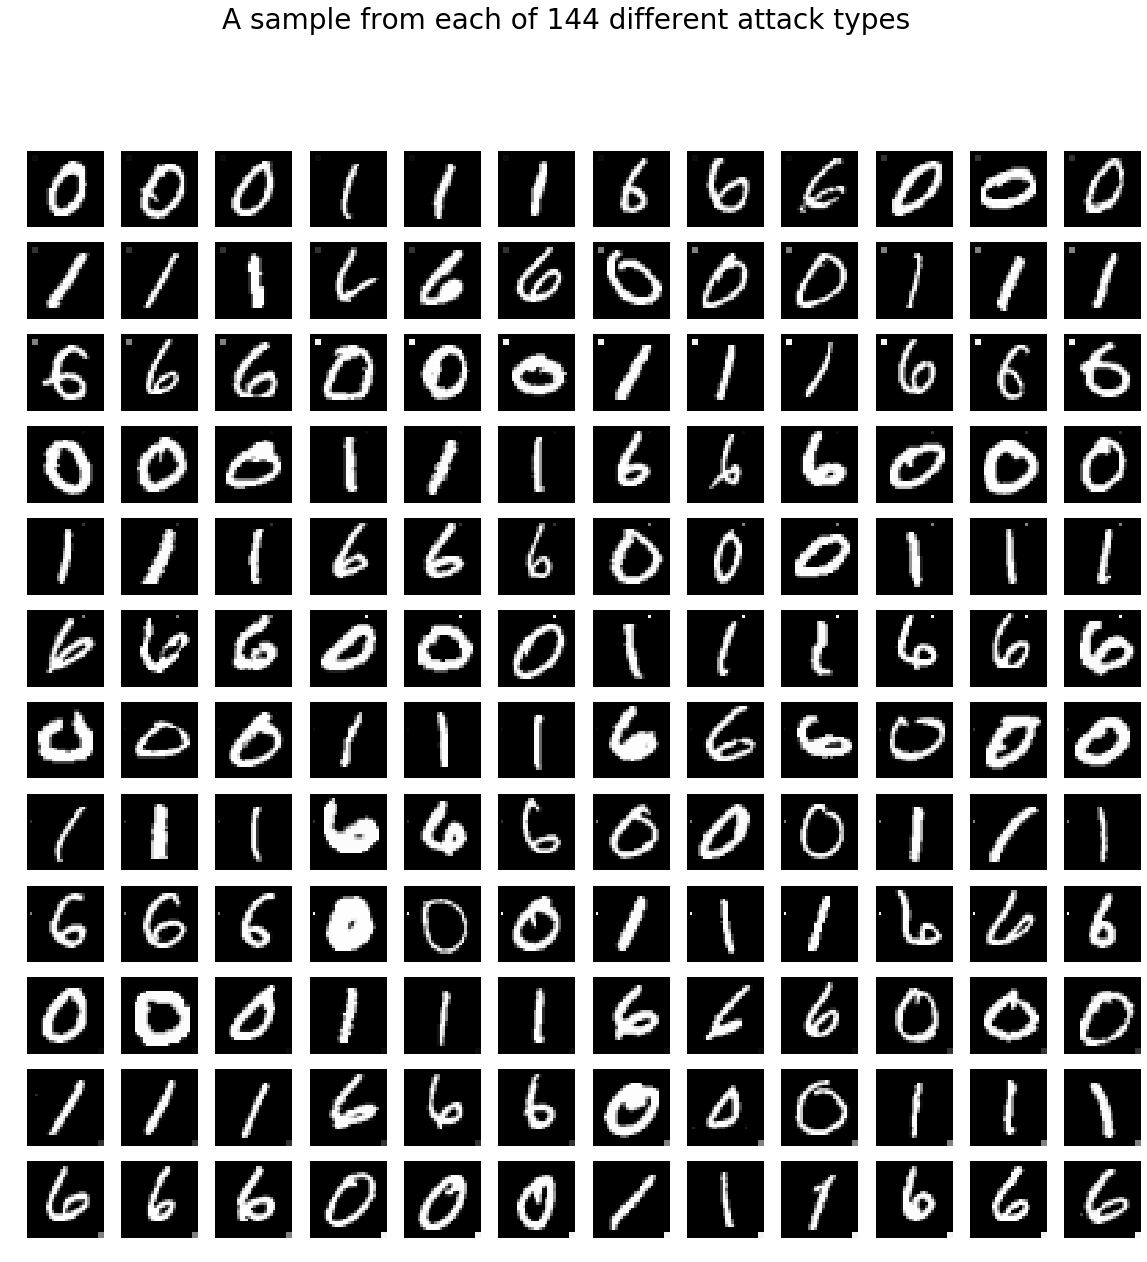

In [7]:
import matplotlib.pyplot as plt
import mnist_poison_util as mnp

def plot_initialize(w=16,h=12):
  %pylab inline
  plt.rcParams['figure.figsize'] = [w,h]
plot_initialize(w=20,h=20)
plt.suptitle("A sample from each of 144 different attack types", fontsize=28)
tr_table_grp = tr_table.groupby(by=['location','color','attack_labels','attack_ratio'])
samples_pois = [data.sample(n=1) for _,data in tr_table_grp]
samples_pois = pd.concat(samples_pois).reset_index(drop=True)
for i,row in samples_pois.iterrows():
  # load train and test set
  train_f = read_bz2_ret_pickle(row.file_loc)
  plt.subplot(12,12,i+1)
  plt.imshow(train_f['p_X'][0,...].reshape((28,28)),cmap='gray')
  plt.axis('off')    

# Poisoned Weights Storage and accessing locations based on layer
Poisoned weights are flattened and they are all in one dimension. Therefore, first you need to gather them in their corresponding layer group in the network architecture

In [8]:
pois_table = read_bz2_ret_pickle('./poisoned_datasets/models/poisoned/gtable-run.pickle.bz2')
poisoned_ds = read_bz2_ret_pickle('./poisoned_datasets/train/gtable.pickle.bz2')
pois_table.head()

,is_clean,log_strategy,rarng_seed,evl_loc,tr_loc,model_loc,evl_acc,attk_succ_rate
0,0.0,last,367646.0,./poisoned_datasets/test/pois_7.pickle.bz2,./poisoned_datasets/train/pois_0.pickle.bz2,./poisoned_datasets/models/poisoned/_weights_0...,"[0.9811, 0.9874, 0.9869, 0.9886, 0.9913, 0.986...","[0.0, 0.0, 0.9612335, 0.9603524, 0.9876652, 0...."
1,0.0,last,321682.0,./poisoned_datasets/test/pois_7.pickle.bz2,./poisoned_datasets/train/pois_0.pickle.bz2,./poisoned_datasets/models/poisoned/_weights_1...,"[0.9815, 0.9878, 0.9873, 0.989, 0.9886, 0.9913...","[0.004405286, 0.0052863434, 0.0052863434, 0.00..."
2,0.0,last,702924.0,./poisoned_datasets/test/pois_7.pickle.bz2,./poisoned_datasets/train/pois_0.pickle.bz2,./poisoned_datasets/models/poisoned/_weights_2...,"[0.9802, 0.989, 0.9902, 0.9881, 0.9865, 0.9883...","[0.0008810573, 0.0, 0.0, 0.98061675, 0.9903083..."
3,0.0,last,835513.0,./poisoned_datasets/test/pois_9.pickle.bz2,./poisoned_datasets/train/pois_1.pickle.bz2,./poisoned_datasets/models/poisoned/_weights_3...,"[0.982, 0.9818, 0.9803, 0.9812, 0.9884, 0.9898...","[0.007929515, 0.0052863434, 0.007929515, 0.346..."
4,0.0,last,309243.0,./poisoned_datasets/test/pois_9.pickle.bz2,./poisoned_datasets/train/pois_1.pickle.bz2,./poisoned_datasets/models/poisoned/_weights_4...,"[0.9823, 0.9902, 0.9899, 0.9904, 0.9918, 0.992...","[0.0070484583, 0.011453745, 0.9788546, 0.98237..."


Let's just pick the location of the first model from the table that has location information from model_loc column. In case you need to select specific models you must join them with poisoned training dataset table (tr_loc), select rows based on criterias, then load corresponding models.

In [9]:
pois_table.iloc[0]['model_loc']
print ('the model is trainined on the dataset {}'.format(pois_table.iloc[0]['tr_loc']))
temp_model = read_bz2_ret_pickle(pois_table.iloc[0]['model_loc'])
poisoned_ds[poisoned_ds.file_loc == pois_table.iloc[0]['tr_loc']]

the model is trainined on the dataset ./poisoned_datasets/train/pois_0.pickle.bz2


,location,color,attack_ratio,attack_labels,p_seed,is_train,file_loc
0,"[(26, 26), (26, 27), (27, 26), (27, 27)]",0.05,0.1,"[(1, 5)]",944325.0,1.0,./poisoned_datasets/train/pois_0.pickle.bz2


Now temp_model is just an example of our models which is a flattend array of size (356234). You should know which indices correspond to which layers to conduct your analysis. For now let's ignore bias variables (starting with B) from our analysis since there are not so many of them, and stick to W's. For this current network I have a sample that keeps track of location of indices for each array named layer_bound

In [11]:
main_graph = tf.Graph()
net = NetSimple(device='/gpu:0',scope = '',n_classes = 10,main_graph=main_graph)
net.create_output_tensors()
net.print_scope_vars_range()

W0:0 ---> (0,287) with length 288 parameters
W1:0 ---> (288,18719) with length 18432 parameters
W2:0 ---> (18720,92447) with length 73728 parameters
W3:0 ---> (92448,354591) with length 262144 parameters
W6:0 ---> (354592,355871) with length 1280 parameters
B0:0 ---> (355872,355903) with length 32 parameters
B1:0 ---> (355904,355967) with length 64 parameters
B2:0 ---> (355968,356095) with length 128 parameters
B3:0 ---> (356096,356223) with length 128 parameters
B4:0 ---> (356224,356233) with length 10 parameters


In [12]:
# These ranges are inclusive
layers_bound = {'conv1':[('W0:0',0,287),],
                'conv2':[('W1:0',288,18719),],
                'conv3':[('W2:0',18720,92447),],
                'fc1':[('W3:0',92448,354591),],
                'fc2':[('W6:0',354592,355871),],}

# Graph Clustering
We would like to conduct two graph clustering algorithm. One is Markov Clustering Algorithm, the other one is spectral clustering. Whichever is assigned to you, please carefully read the documentation on their parameters
1. https://github.com/GuyAllard/markov_clustering
2. https://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html

You can start with small random samples from both clean and poisoned models (50%,50%). For these graph clustering algorithms to work, we would consider each model as a node, and there will be an edge between any two nodes that has the similarity score (different similarities that should be tested and defined below) between these models

## Similarity Measures
1. Cos similarity (The closer this value is to zero the more similar two samples are) (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html#sklearn-metrics-pairwise-cosine-similarity)
2. Test statistics value of Kolmogrov Smirnov two sample test (The lower the closer two samples are) (https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.ks_2samp.html)

## Test for different layers
According to our initial analysis the most important layers are conv2, conv3,and fc1, but I want you to test similarities between models on all layers separately.

## Selecting a sample of weights
For layers that are larger than our threshold (500,1000,5000),let's sample according to following algorithm:
1. Sort values
2. Recursively, remove even records until you have the necessary amount of samples
Again, here we would like to have tests for all this sample selection size. Please keep this new order of sorted values before feeding it to similarity measure function
## Some possible optimization
1. When creating this fully connected graph of similarities between any two models in experiment (poisoned and clean) you can only keep some percentage of top similarities. You can test for values such as 100%, 50%,20%,10%, and 5%.
## Goal
We would like to know if we can separate the clean runs and poisoned runs into separate clusters, or at least most of them. The best scenario would be to see if we can have one cluster for most clean runs and another one for the rest. But, it is possible that we may need more clusters, then as long as we can separate out most if the cleans, that should be good too.

In [13]:
# Sample code for rank eliminate
def rank_eliminate(w,remove_odd = False,thresh_size=None):
  if thresh_size is None:
    raise Exception('Threshold size should be given')
  w = w.reshape((1,-1))
  w = np.sort(w)
  start_ind = 1 if remove_odd else 0
  while w.shape[1] > thresh_size:
    rem_ind = np.arange(start_ind,w.shape[1],2,dtype=int)
    if w.shape[1] - len(rem_ind) < thresh_size:
      rem_ind = rem_ind[:w.shape[1]-thresh_size]
    w = np.delete(w,rem_ind,axis=1)
  return w.reshape((-1,))

